In [155]:
import os
import tensorflow as tf
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

figsize=(10, 6)
export_dir = './'
data_dir = '../data/'

sns.set()
sns.set_context("paper")

In [156]:
def get_section_results(file, policy_name, *tags):
    data_dict = {'env_step': [], 'policy': []}
    data_dict.update({tag: [] for tag in tags})
    for e in tf.compat.v1.train.summary_iterator(file):
        prev_step = -1
        for v in e.summary.value:
            if v.tag in data_dict:
                data_dict[v.tag].append(v.simple_value)
                if prev_step != e.step:
                    prev_step = e.step
                    data_dict['env_step'].append(e.step)
                    data_dict['policy'].append(policy_name)
    data_dict = {tag: np.array(data_dict[tag]) for tag in data_dict}
    return data_dict

In [165]:
def read_data(policy_name, size):
    full_data = pd.DataFrame()
    plot_data = pd.DataFrame()

    for folder in os.scandir(os.path.join(data_dir, policy_name, 'logs')):
        if folder.is_dir():
            logdir = os.path.join(folder, 'events*')
            eventfile = glob.glob(logdir)[0]
            data_dict = get_section_results(eventfile, policy_name, 'input_info/advantage', 'input_info/clip_range', 'input_info/discounted_rewards',\
                                             'input_info/learning_rate','loss/approximate_kullback-leibler', 'loss/clip_factor', 'loss/entropy_loss',\
                                             'loss/loss' ,'loss/policy_gradient_loss', 'loss/value_function_loss')
            data = pd.DataFrame(data_dict)
            for (columnName, columnData) in data.iteritems():
                if columnName != 'env_step' and columnName != 'policy':
                    data[f'{columnName}_smooth'] = data[columnName].ewm(alpha=0.002).mean()

            # reduce size for plotting
            count_row = data.shape[0]
            reduced_row = np.linspace(0, count_row-1, size, dtype=int, endpoint=True)
            data_p = data.iloc[reduced_row]

            full_data = pd.concat([full_data, data], axis=0)
            plot_data = pd.concat([plot_data, data_p], axis=0)
    return full_data, plot_data

In [171]:
FCP_s3, FCP_s3_plot = read_data('FCP_tictactoe_20M_s3',500)
FCP_s5, FCP_s5_plot = read_data('FCP_tictactoe_20M_s5',500)
FCP_s10, FCP_s10_plot = read_data('FCP_tictactoe_20M_s10',500)
PP_s3, PP_s3_plot = read_data('PP_tictactoe_20M_s3',500)
PP_s5, PP_s5_plot = read_data('PP_tictactoe_20M_s5',500)
PP_s10, PP_s10_plot = read_data('PP_tictactoe_20M_s10',500)
SP_s5, SP_s5_plot = read_data('SP_tictactoe_10M_s5',500)

data_plot = pd.concat([SP_s5_plot, PP_s3_plot, PP_s5_plot, PP_s10_plot, FCP_s3_plot, FCP_s5_plot, FCP_s10_plot], axis=0)

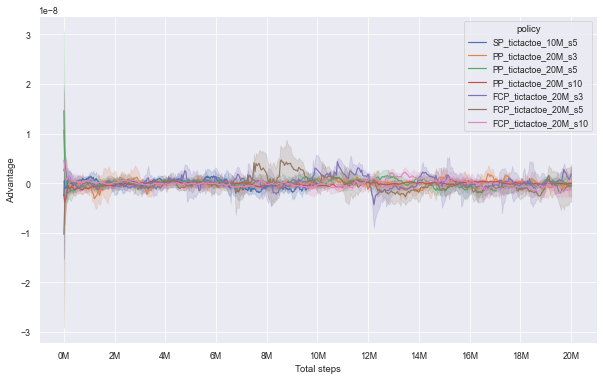

In [173]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='input_info/advantage_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Advantage')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_advantage.pdf'), bbox_inches='tight')

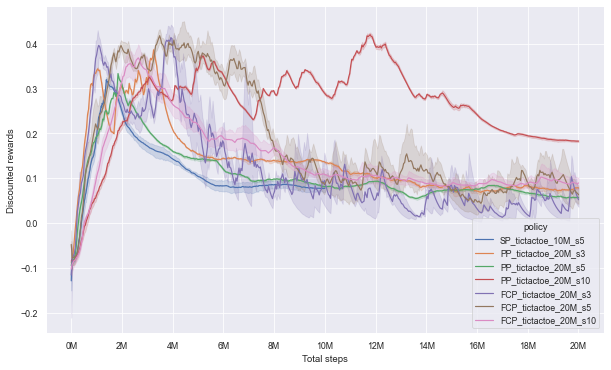

In [181]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='input_info/discounted_rewards_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Discounted rewards')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_discounted_reward.pdf'), bbox_inches='tight')

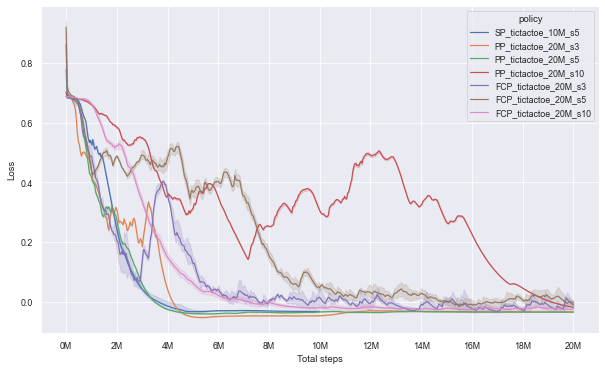

In [182]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_loss.pdf'), bbox_inches='tight')

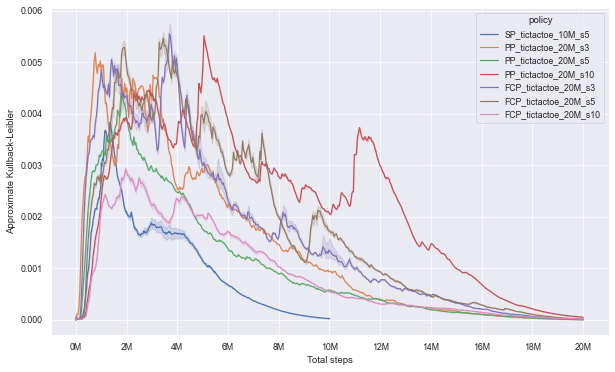

In [183]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/approximate_kullback-leibler_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Approximate Kullback-Leibler')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_approx_kl.pdf'), bbox_inches='tight')

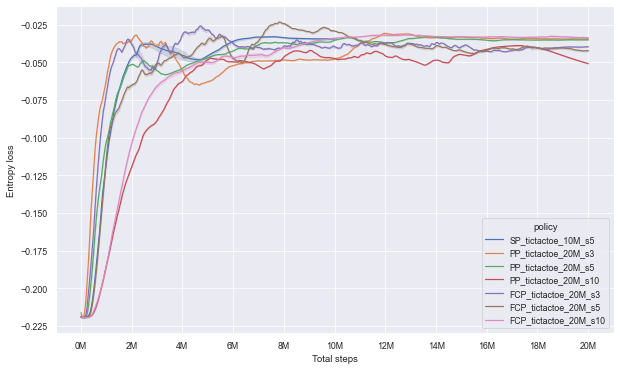

In [184]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/entropy_loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Entropy loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_entropy_loss.pdf'), bbox_inches='tight')

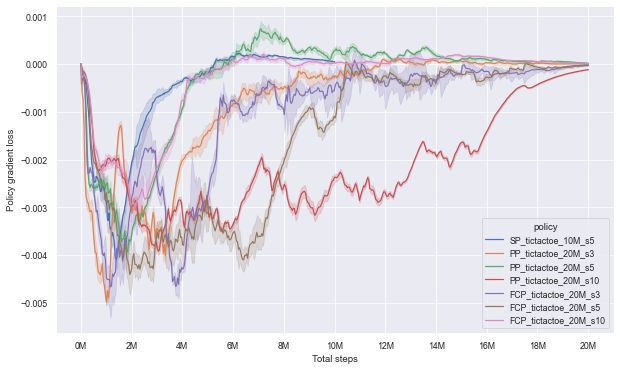

In [188]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/policy_gradient_loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Policy gradient loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_policy_gradient_loss.pdf'), bbox_inches='tight')

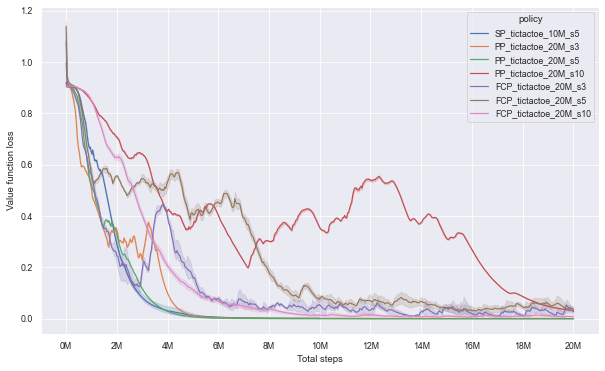

In [186]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/value_function_loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Value function loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_value_function_loss.pdf'), bbox_inches='tight')